<a href="https://colab.research.google.com/github/bbartlett4/Edible-Mushroom/blob/main/Mushrooms_Batch20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub 
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
from sklearn.model_selection import train_test_split
from google.colab import drive
import shutil 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import time

In [2]:
def show_image(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(228, 228))
    plt.imshow(img)
    plt.show()

In [3]:
def preprocess_image(item):
    image_string = tf.io.read_file(item[0])
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize(image_decoded, (IMAGE_SIZE, IMAGE_SIZE))
    image_resized = tf.cast(image_resized, tf.float32) / 255.0
    return image_resized, tf.strings.to_number(item[1], tf.int64)

In [4]:
def get_dataset(edible_fungies, poisonous_fungies, mode, batch_size):
    x = list(edible_fungies) + list(poisonous_fungies)
    y = [0] * len(edible_fungies) + [1] * len(poisonous_fungies)
    items = [(a, b) for (a, b) in zip(x, y)]
    dataset = tf.data.Dataset.from_tensor_slices(np.array(items)).shuffle(len(x))
    dataset = dataset.map(preprocess_image).batch(batch_size)
    return dataset

In [5]:
def get_balanced_dataset(edible_fungies, poisonous_fungies, batch_count, batch_size, mode="train"):
    length_per_category = batch_size * batch_count // 2
    edible_indices = np.random.choice(len(edible_fungies), length_per_category)
    poisonous_indices = np.random.choice(len(poisonous_fungies), length_per_category)
    samle_count = 2 * length_per_category
    return get_dataset(
        edible_fungies[edible_indices], 
        poisonous_fungies[poisonous_indices], 
        mode, 
        batch_size
    ), samle_count

In [ ]:
def augment_image(Type,Amount):
    size=(IMAGE_SIZE,IMAGE_SIZE)

    # create and store the augmented images
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=90, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
    
    from_dir=os.path.join(TRAIN_DIR,Type)
    print(from_dir) 
    target_dir=os.path.join(AUG_DIR,Type)  # define where to write the images 

    aug_gen=gen.flow_from_directory( TRAIN_DIR,   target_size=size, classes=[Type],
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
    count=0
    
    while count<Amount:
      images=next(aug_gen)            
      count+=1


Only Run to insert Data First Time

In [6]:
drive.mount('/content/drive')

# feel free to edit this cell to work with your local or colab directory
WORKING_DIR = '/content/drive/My Drive/Colab Notebooks/Project Data'
TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/Project Data/train'
VAL_DIR = '/content/drive/My Drive/Colab Notebooks/Project Data/val'
AUG_DIR = '/content/drive/My Drive/Colab Notebooks/Project Data/aug'



Mounted at /content/drive


In [ ]:
#ONLY RUN ONCE
os.makedirs(AUG_DIR)
os.makedirs(os.path.join(AUG_DIR,'edible mushroom sporocarp'))
os.makedirs(os.path.join(AUG_DIR,'edible sporocarp'))
os.makedirs(os.path.join(AUG_DIR,'poisonous mushroom sporocarp'))
os.makedirs(os.path.join(AUG_DIR,'poisonous sporocarp'))


In [ ]:
lables = ["edible", "poisonous"]
directory_group = [
    ['edible mushroom sporocarp', 'edible sporocarp'], 
    ['poisonous mushroom sporocarp', 'poisonous sporocarp']]



shutil.move(os.path.join(WORKING_DIR,'edible mushroom sporocarp'), os.path.join(TRAIN_DIR, 'edible mushroom sporocarp'))
shutil.move(os.path.join(WORKING_DIR,'edible sporocarp'), os.path.join(TRAIN_DIR, 'edible'))
shutil.move(os.path.join(WORKING_DIR,'poisonous mushroom sporocarp'), os.path.join(TRAIN_DIR, 'poisonous mushroom sporocarp'))
shutil.move(os.path.join(WORKING_DIR,'poisonous sporocarp'), os.path.join(TRAIN_DIR, 'poisonous sporocarp'))


In [7]:
IMAGE_SIZE = 224
EdibleMushroom = glob(TRAIN_DIR + '/edible mushroom sporocarp/*.jpg')
EdibleSporo = glob(TRAIN_DIR + '/edible sporocarp/*.jpg')
PoisonMushroom = glob(TRAIN_DIR + '/poisonous mushroom sporocarp/*.jpg')
PoisonSporo = glob(TRAIN_DIR + '/poisonous sporocarp/*.jpg')


In [ ]:
augment_image('edible mushroom sporocarp',500)
augment_image('edible sporocarp',500)
augment_image('poisonous mushroom sporocarp',500)
augment_image('poisonous sporocarp',500)

In [8]:
EdibleMushroomAUG = glob(AUG_DIR + '/edible mushroom sporocarp/*.jpg')
EdibleSporoAUG = glob(AUG_DIR + '/edible sporocarp/*.jpg')
PoisonMushroomAUG = glob(AUG_DIR + '/poisonous mushroom sporocarp/*.jpg')
PoisonSporoAUG = glob(AUG_DIR + '/poisonous sporocarp/*.jpg')
edible_fungies = list(set(EdibleMushroom).union(set(EdibleSporo).union(set(EdibleSporoAUG).union(set(EdibleMushroomAUG)))))
poisonous_fungies = list(set(PoisonMushroom).union(set(PoisonSporo).union(set(PoisonMushroom).union(set(PoisonSporo)))))

In [9]:
batch_size = 32
validation_split = 0.2
edible_fungies_split_index = int((1 - validation_split) * len(edible_fungies))
poisonous_fungies_split_index = int((1 - validation_split) * len(poisonous_fungies))
train_edible_fungies, valid_edible_fungies = edible_fungies[:edible_fungies_split_index],  edible_fungies[edible_fungies_split_index:] 
train_poisonous_fungies, valid_poisonous_fungies = poisonous_fungies[:poisonous_fungies_split_index],  poisonous_fungies[poisonous_fungies_split_index:] 
print(len(train_edible_fungies), len(valid_edible_fungies))
print(len(train_poisonous_fungies), len(valid_poisonous_fungies))
num_batch_per_epoch = min(len(train_edible_fungies), len(train_poisonous_fungies)) // batch_size
print(num_batch_per_epoch)
num_epochs = 20
train_edible_fungies = np.array(train_edible_fungies)
valid_edible_fungies = np.array(valid_edible_fungies)
train_poisonous_fungies = np.array(train_poisonous_fungies)
valid_poisonous_fungies = np.array(valid_poisonous_fungies)
total_valid_count = len(valid_edible_fungies) + len(valid_poisonous_fungies)

1688 423
1643 411
51


In [ ]:
len(edible_fungies)

2111

In [ ]:
len(poisonous_fungies)

2054

In [ ]:
edible_fungies[:10]

['/content/drive/My Drive/Colab Notebooks/Project Data/train/edible mushroom sporocarp/ce (600).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/edible sporocarp/ncvc (169).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/edible mushroom sporocarp/ce (584).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/aug/edible mushroom sporocarp/aug-_124_671063.jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/edible mushroom sporocarp/ce (385).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/aug/edible sporocarp/aug-_5_4032410.jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/edible sporocarp/ncvc (309).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/edible mushroom sporocarp/ce (272).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/edible mushroom sporocarp/ce (674).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/edible sporocarp/ncvc (268).jpg']

In [ ]:
poisonous_fungies[:10]

['/content/drive/My Drive/Colab Notebooks/Project Data/train/poisonous sporocarp/nncv (655).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/poisonous sporocarp/nncv (633).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/poisonous mushroom sporocarp/cv (776).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/poisonous sporocarp/nncv (248).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/poisonous sporocarp/nncv (611).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/poisonous sporocarp/nncv (602).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/poisonous sporocarp/nncv (779).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/poisonous sporocarp/nncv (828).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/poisonous mushroom sporocarp/cv (80).jpg',
 '/content/drive/My Drive/Colab Notebooks/Project Data/train/poisonous mushroom sporocarp/cv (207).jpg']

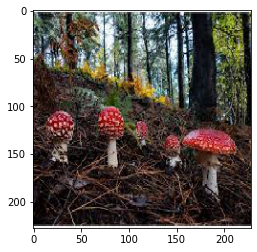

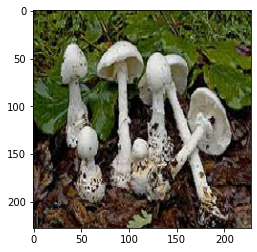

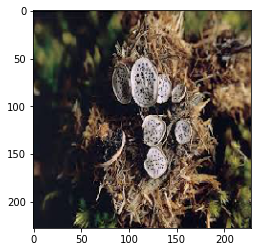

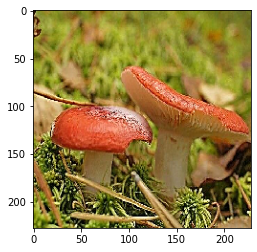

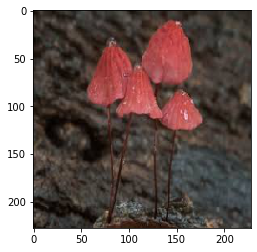

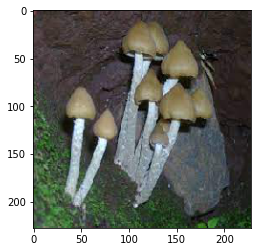

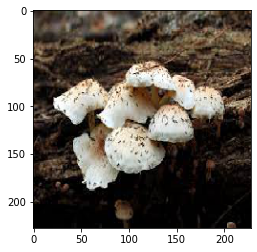

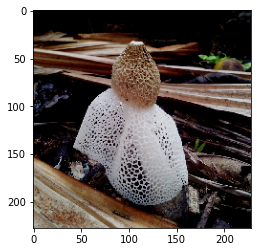

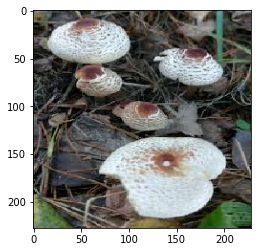

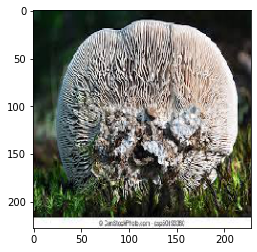

In [ ]:
for i in range(10):
    show_image(poisonous_fungies[np.random.randint(len(poisonous_fungies))])

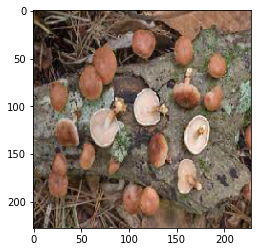

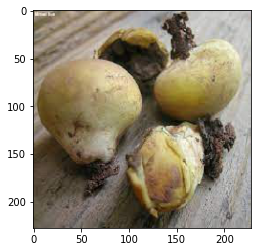

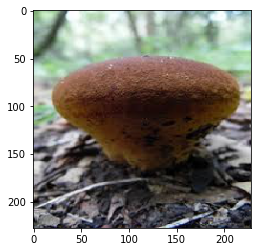

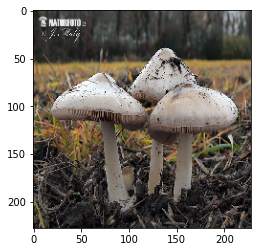

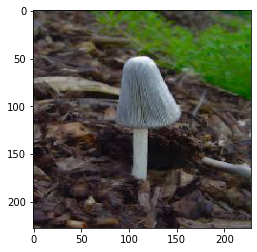

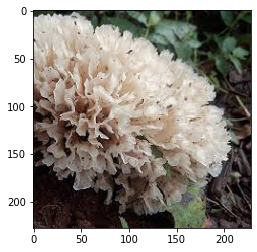

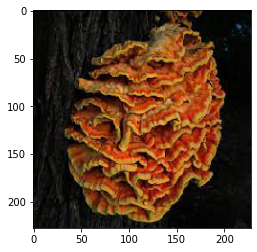

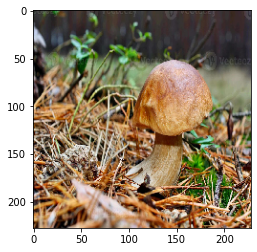

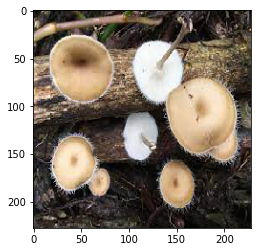

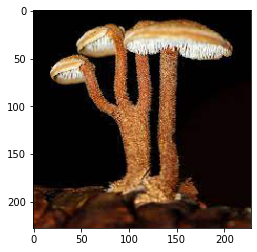

In [ ]:
for i in range(10):
    show_image(edible_fungies[np.random.randint(len(edible_fungies))])

In [10]:
handle_base = "mobilenet_v2"
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
feature_extractor.trainable = False  

In [11]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 6

In [12]:
valid_dataset = get_dataset(valid_edible_fungies, valid_poisonous_fungies, "valid", batch_size)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
history = {
    "train_loss": [],
    "valid_loss": [],
    "train_accuracy": [],
    "valid_accuracy": []
}
for epoch in range(num_epochs):
    begin_time = time.time()
    train_dataset, total_train_count = get_balanced_dataset(train_edible_fungies, train_poisonous_fungies, num_batch_per_epoch, batch_size, mode="train")
    train_losses = []
    valid_losses = []
    correct_count = 0
    total_count = 0
    for (x_batch, y_true) in train_dataset:
        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            predict_labels = tf.argmax(y_pred, axis=-1)
            loss_value = loss(y_true, y_pred)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_losses.append(loss_value)
        correct_count += tf.reduce_sum(tf.cast(y_true == predict_labels, tf.int64))
        total_count += y_true.shape[0]
    train_loss = tf.reduce_mean(train_losses)
    train_accuracy = correct_count / total_train_count
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    correct_count = 0
    total_count = 0
    for (x_batch, y_true) in valid_dataset:
        y_pred = model(x_batch)
        predict_labels = tf.argmax(y_pred, axis=-1)
        loss_value = loss(y_true, y_pred)
        valid_losses.append(loss_value)
        correct_count += tf.reduce_sum(tf.cast(y_true == predict_labels, tf.int64))
        total_count += y_true.shape[0]
    valid_loss = tf.reduce_mean(valid_losses)
    valid_accuracy = correct_count / total_valid_count
    history["valid_loss"].append(valid_loss)
    history["valid_accuracy"].append(valid_accuracy)
    elapsed_time = time.time() -  begin_time
    print("Epoch: %d / %d"%(epoch + 1, num_epochs))
    print("%.2fs Loss: %.2f Accuracy: %.2f Validation Loss: %.2f Validation Accuracy: %.2f"%(elapsed_time, train_loss, train_accuracy, valid_loss, valid_accuracy))
for key in history:
    history[key] = list(np.array(history[key]))

Epoch: 1 / 20
403.96s Loss: 0.52 Accuracy: 0.72 Validation Loss: 0.45 Validation Accuracy: 0.78
Epoch: 2 / 20
277.49s Loss: 0.35 Accuracy: 0.83 Validation Loss: 0.39 Validation Accuracy: 0.81
Epoch: 3 / 20
273.37s Loss: 0.30 Accuracy: 0.86 Validation Loss: 0.36 Validation Accuracy: 0.82
Epoch: 4 / 20
302.91s Loss: 0.26 Accuracy: 0.89 Validation Loss: 0.39 Validation Accuracy: 0.82
Epoch: 5 / 20
274.36s Loss: 0.21 Accuracy: 0.91 Validation Loss: 0.35 Validation Accuracy: 0.84
Epoch: 6 / 20
302.91s Loss: 0.19 Accuracy: 0.92 Validation Loss: 0.37 Validation Accuracy: 0.83
Epoch: 7 / 20
302.91s Loss: 0.16 Accuracy: 0.95 Validation Loss: 0.35 Validation Accuracy: 0.82
Epoch: 8 / 20
302.91s Loss: 0.15 Accuracy: 0.94 Validation Loss: 0.34 Validation Accuracy: 0.85
Epoch: 9 / 20
302.92s Loss: 0.15 Accuracy: 0.95 Validation Loss: 0.34 Validation Accuracy: 0.86
Epoch: 10 / 20
256.74s Loss: 0.12 Accuracy: 0.96 Validation Loss: 0.36 Validation Accuracy: 0.86
Epoch: 11 / 20
302.91s Loss: 0.11 Accur

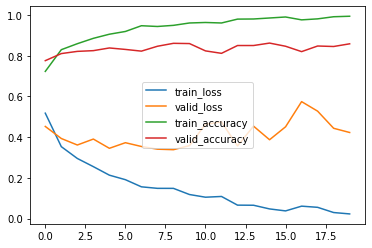

In [13]:
pd.DataFrame(history).plot()

In [14]:
predicted_labels = []
actual_labels = []
for (x_batch, y_true) in valid_dataset:
    y_pred = model(x_batch)
    predicted_labels += list(np.array(tf.argmax(y_pred, axis=-1)))
    actual_labels += list(np.array(y_true))

[[353  70]
 [ 48 363]]


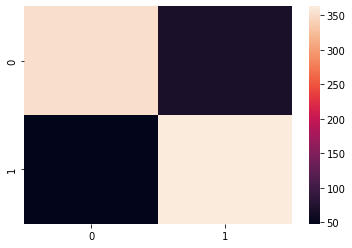

In [15]:
matrix = confusion_matrix(actual_labels, predicted_labels)
print(matrix)
sns.heatmap(matrix)

In [16]:
cls_report = classification_report(predicted_labels, actual_labels)
print(cls_report)

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       401
           1       0.88      0.84      0.86       433

    accuracy                           0.86       834
   macro avg       0.86      0.86      0.86       834
weighted avg       0.86      0.86      0.86       834



In [ ]:
model.save("model.h5")